# Problem Set 6: Particle Tracking

## 1 Particle Filter Tracking

### 1-1

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display

In [2]:
def plotVideo(title):
    vc = cv2.VideoCapture(title)
    is_capturing, frame = vc.read()
    preview = plt.imshow(frame) 

    while is_capturing:


            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
            preview.set_data(frame)
            plt.draw()
            plt.xticks([]), plt.yticks([])
            display.display(plt.gcf())
            is_capturing, frame = vc.read()
            display.clear_output(wait=True)

In [3]:
def getFrame(n,title):
    video = cv2.VideoCapture(title)
    i=0
    while i<=n:
        is_capturing, frame = video.read()
        if(not is_capturing):
            print("Not enough frames in the video for frame "+str(i))
            return -1
        else:
            if i==n:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
                return frame
        i+=1
    print("Unexpected error")
    return -1

In [4]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range,  N):
    particles = np.empty((N, 3))
    particlesX = uniform(x_range[0], x_range[1], size=N)
    particlesY = uniform(y_range[0], y_range[1], size=N)
    return particlesX, particlesY

In [5]:
def plotImage(image,title):
    plt.imshow(image)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

In [6]:
def plotImageParticles(image,title,pX,pY,yHalfWin,xHalfWin,weight):
    fig,ax=plt.subplots(1)
    h,w,_ = image.shape
    ax.imshow(image)
    plt.title(title), plt.xticks([]), plt.yticks([])
    Xmean=np.average(pX,weights=weight)
    Ymean=np.average(pY,weights=weight)
    
    dist=[]
    for i in range(0,len(pX)):
        dist.append(np.linalg.norm(pX[i]-Xmean)+np.linalg.norm(pY[i]-Ymean))
        
    
    rad=np.sum(dist*weight)
    
    ax.add_patch(patches.Rectangle((Xmean-xHalfWin,Ymean-yHalfWin),
                                       2*xHalfWin,
                                       2*yHalfWin,
                                       fill=False))
    ax.add_patch(patches.Circle((Xmean,Ymean),rad,fill=False))
    pX[pX<1]=1
    pY[pY<1]=1
    pX[pX>w-1]=w-1
    pY[pY>h-1]=h-1
    ax.scatter(pX,pY,s=1)
    plt.show()

In [7]:
boxPres=np.loadtxt('pres_debate.txt')
topLeftPres=boxPres[0:2]
sizePres=boxPres[2:4]

In [8]:
def predict(particlesX,particlesY, std):
    N = len(particlesX)
    particlesX += np.random.normal(0,std,N)
    particlesY += np.random.normal(0,std,N)
    return particlesX, particlesY

In [9]:
def particleFilter(topLeft,sizeBox,video,N,std=50,sMSE=10,noiseMax=50,frames=range(0,500)):
    
    xHalfWin=sizeBox[0]//2
    yHalfWin=sizeBox[1]//2
    
    x_left=int(topLeft[0])
    x_right=int(topLeft[0]+2*xHalfWin)
    y_top=int(topLeft[1])
    y_bottom=int(topLeft[1]+2*yHalfWin)
    
    x_rangeInit=[x_left,x_right]
    y_rangeInit=[y_top,y_bottom]
    
    frame0=getFrame(0,video)
    particlesX, particlesY=create_uniform_particles(x_rangeInit, y_rangeInit,  N)
    
    weights=np.ones(N)
    weights=weights/N
    plotImageParticles(frame0,"Frame 0 of pres debate",particlesX, particlesY,yHalfWin,xHalfWin,weights)
    template= getWindow(frame0,y_top,y_bottom,x_left,x_right)
    
    plotImage(template,"Template")
    
    
    vc = cv2.VideoCapture(video)
    is_capturing, frame = vc.read()

    j=0
    while is_capturing:
            
            
            
        frameI = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        particlesX, particlesY = predict(particlesX,particlesY, std)
        

        probList=[]
        #maxi=0
        for i,x in enumerate(particlesX):
            y=particlesY[i]
            part=getWindow(frameI,int(y-yHalfWin),int(y+yHalfWin),int(x-xHalfWin),int(x+xHalfWin))
            probList.append(getProb(mse(part,template),sMSE))
            #if(probList[i]>maxi):
            #    maxi=probList[i]
            #    bestPart=part

        probList=np.asarray(probList)

        probList=probList/probList.sum(0)
        
        #maxi=np.argmax(probList)
        #plotImage(bestPart,"Template")
        
        
        if(j in frames):
            plotImageParticles(frameI,"Frame "+str(j)+" of pres debate with preds",particlesX, particlesY,yHalfWin,xHalfWin,probList)
        
        
        particlesX,particlesY=resampleDiffuse(particlesX,particlesY,probList,noiseMax)

        is_capturing, frame = vc.read()
        j+=1
    
    

In [10]:
def getWindow(image,y_top,y_bottom,x_left,x_right):
    template = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    template=template[y_top:y_bottom,x_left:x_right]
    return template

In [11]:
def mse(imageA, imageB):
    try:
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err
    except:
        return 9999999999
    

In [12]:
def getProb(mse,s=10):
    return np.exp(-mse/(2*s**2))

In [13]:
def resampleDiffuse(particlesX,particlesY, weights, noiseMax=50):
    N = len(weights)
    indexes=np.random.choice(range(N),N,p=weights)
            
    particlesX[:] = particlesX[indexes]
    particlesY[:] = particlesY[indexes]
    
    particlesX=particlesX+np.random.normal(scale=noiseMax,size=N)
   
    
    particlesY=particlesY+np.random.normal(scale=noiseMax,size=N)
    return particlesX,particlesY

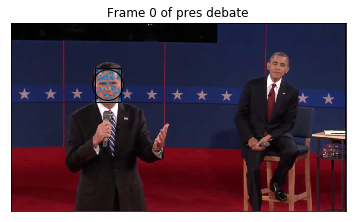

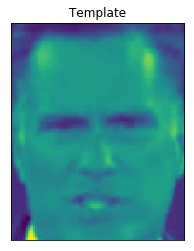

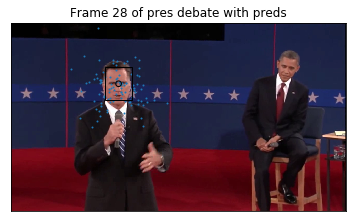

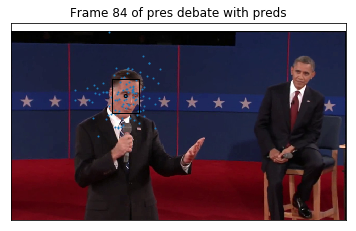

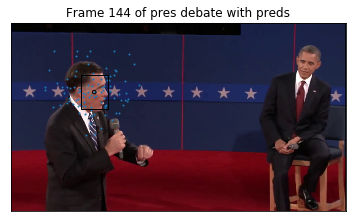

In [17]:
particleFilter(topLeftPres,sizePres,'pres_debate.avi',100,frames=[28,84,144])

### 1-2

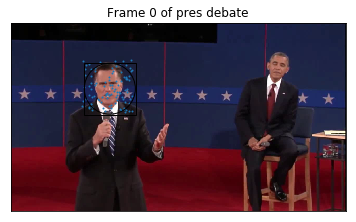

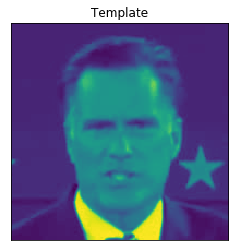

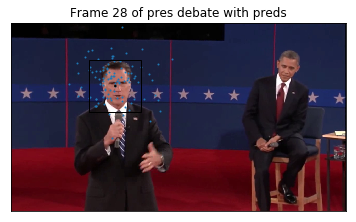

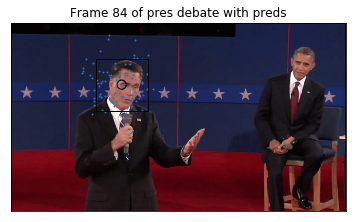

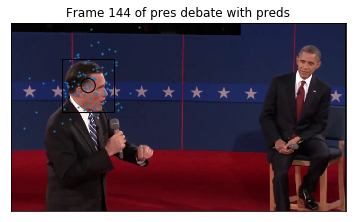

In [18]:
particleFilter([270,140],[200,200],'pres_debate.avi',100,frames=[28,84,144])

We notice that with a larger window size the system is more likely to catch the shape of the shoulders as well, but it will need more particles. It seems a bit more robust.

### 1-3

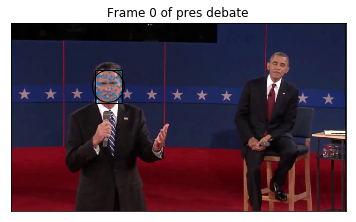

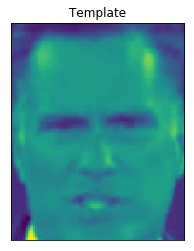

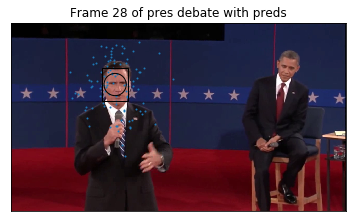

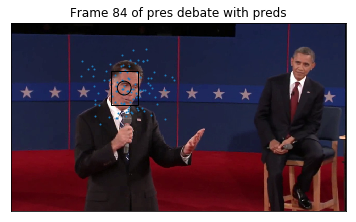

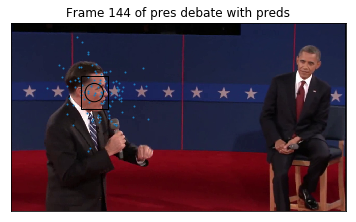

In [19]:
particleFilter(topLeftPres,sizePres,'pres_debate.avi',100,sMSE=20,frames=[28,84,144])

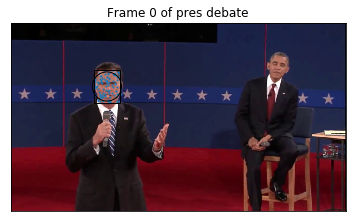

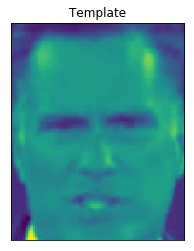

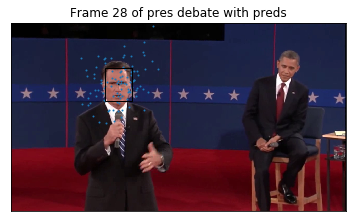

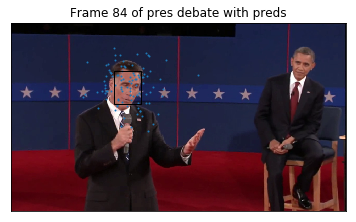

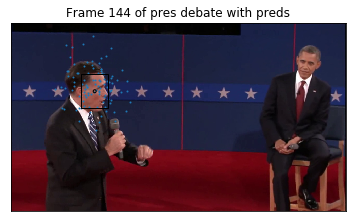

In [22]:
particleFilter(topLeftPres,sizePres,'pres_debate.avi',100,sMSE=5,frames=[28,84,144])

A lower sigma tends to be more stable, but less robust to unpredicted changes

### 1-4

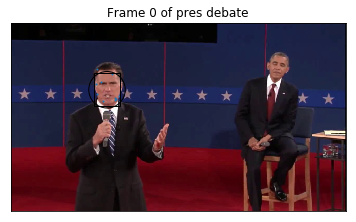

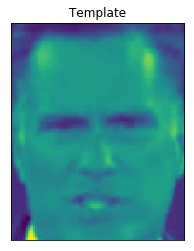

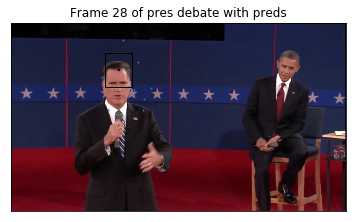

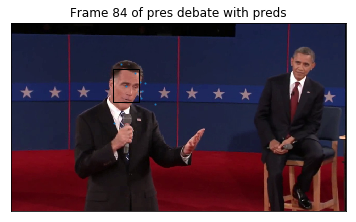

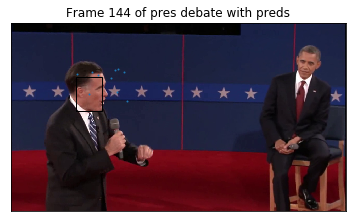

In [23]:
particleFilter(topLeftPres,sizePres,'pres_debate.avi',10,sMSE=10,frames=[28,84,144])

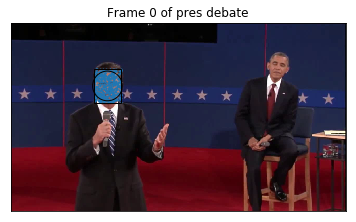

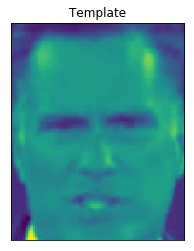

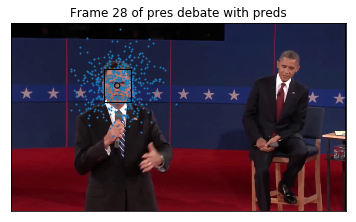

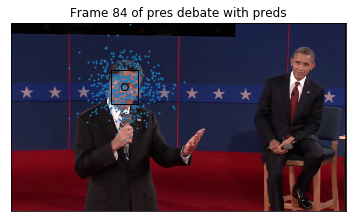

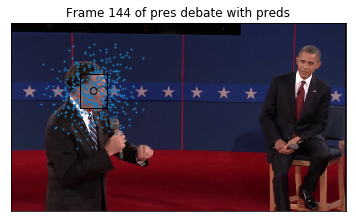

In [25]:
particleFilter(topLeftPres,sizePres,'pres_debate.avi',500,sMSE=10,frames=[28,84,144])

The more particles, the better the result. But what we gain in accuracy we loose in speed.

### 1-5

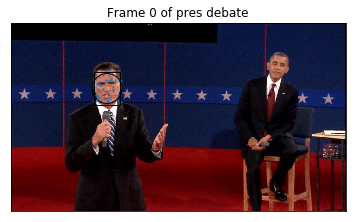

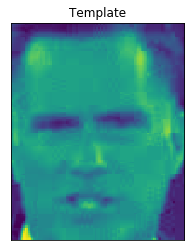

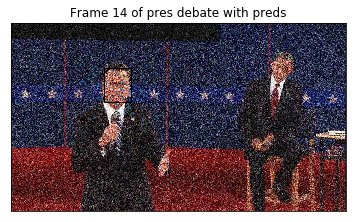

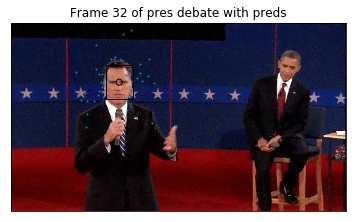

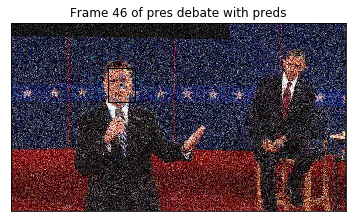

In [26]:
particleFilter(topLeftPres,sizePres,'noisy_debate.avi',50,sMSE=10,frames=[14,32,46])

Obviously,noisy phases tend to confuse the particles

## 2 Appearance Model Update

### 2-1

In [27]:
def particleFilterDinamyc(topLeft,sizeBox,video,N,frames,std=20,sMSE=10,alpha=0.95,noiseMax=50):
    
    xHalfWin=sizeBox[0]//2
    yHalfWin=sizeBox[1]//2
    
    x_left=int(topLeft[0])
    x_right=int(topLeft[0]+2*xHalfWin)
    y_top=int(topLeft[1])
    y_bottom=int(topLeft[1]+2*yHalfWin)
    
    x_rangeInit=[x_left,x_right]
    y_rangeInit=[y_top,y_bottom]
    
    frame0=getFrame(0,video)
    particlesX, particlesY=create_uniform_particles(x_rangeInit, y_rangeInit,  N)
    
    weights=np.ones(N)
    weights=weights/N
    plotImageParticles(frame0,"Frame 0 of pres debate",particlesX, particlesY,yHalfWin,xHalfWin,weights)
    template= getWindow(frame0,y_top,y_bottom,x_left,x_right)
    
    plotImage(template,"Template")
    
    
    vc = cv2.VideoCapture(video)
    is_capturing, frame = vc.read()

    j=0
    while is_capturing:
            
            
            
        frameI = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        particlesX, particlesY = predict(particlesX,particlesY, std)
        

        probList=[]
        maxi=0
        for i,x in enumerate(particlesX):
            y=particlesY[i]
            part=getWindow(frameI,int(y-yHalfWin),int(y+yHalfWin),int(x-xHalfWin),int(x+xHalfWin))
            probList.append(getProb(mse(part,template),sMSE))
            if(probList[i]>maxi):
                maxi=probList[i]
                bestPart=part

        probList=np.asarray(probList)

        probList=probList/probList.sum(0)
        
        template=(1-alpha)*template+alpha*bestPart
        
        
        if(j in frames):
            plotImageParticles(frameI,"Frame "+str(j)+" of pres debate with preds",particlesX, particlesY,yHalfWin,xHalfWin,probList)
        
        
        particlesX,particlesY=resampleDiffuse(particlesX,particlesY,probList,noiseMax)

        is_capturing, frame = vc.read()
        j+=1
    
    

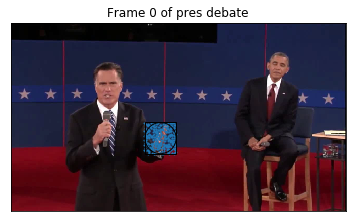

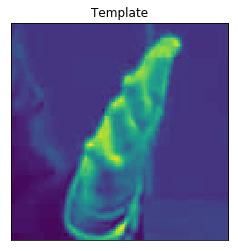

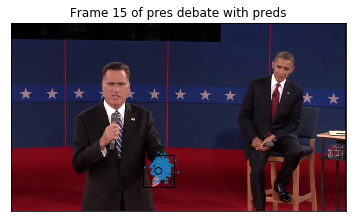

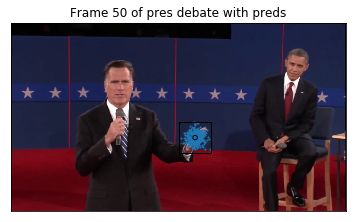

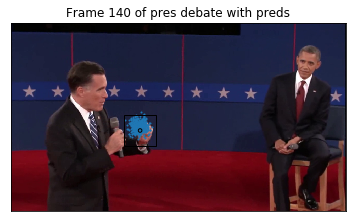

In [28]:
particleFilterDinamyc([510,380],[120,120],'pres_debate.avi',frames=[15,50,140],N=400,std=10,sMSE=10,noiseMax=15,alpha=0.65)

In [30]:
### 2-2

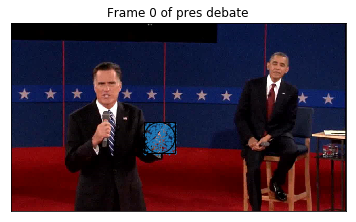

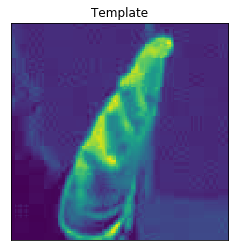

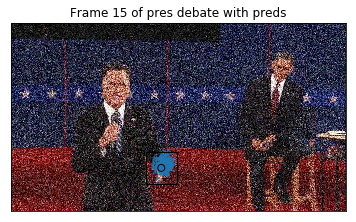

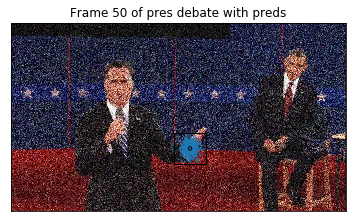

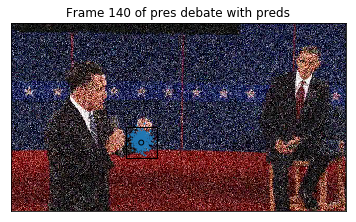

In [29]:
particleFilterDinamyc([510,380],[120,120],'noisy_debate.avi',frames=[15,50,140],N=400,std=10,sMSE=10,noiseMax=15,alpha=0.65)

I had to tune alpha, the noise, andthe number of particles

## 3 Incorporating More Dynamics

In [53]:
def particleFilterDinamycWin(topLeft,sizeBox,video,N,frames,std=20,sMSE=10,alpha=0.95,noiseMax=50):
    
    xHalfWin=sizeBox[0]//2
    yHalfWin=sizeBox[1]//2
    
    x_left=int(topLeft[0])
    x_right=int(topLeft[0]+2*xHalfWin)
    y_top=int(topLeft[1])
    y_bottom=int(topLeft[1]+2*yHalfWin)
    
    ratioHalf=(xHalfWin/yHalfWin)
    
    x_rangeInit=[x_left,x_right]
    y_rangeInit=[y_top,y_bottom]
    
    frame0=getFrame(0,video)
    h,w,_=frame0.shape
    particlesX, particlesY=create_uniform_particles(x_rangeInit, y_rangeInit,  N)
    
    weights=np.ones(N)
    weights=weights/N
    plotImageParticles(frame0,"Frame 0 of pres debate",particlesX, particlesY,yHalfWin,xHalfWin,weights)
    template= getWindow(frame0,y_top,y_bottom,x_left,x_right)
    
    plotImage(template,"Template")
    
    
    vc = cv2.VideoCapture(video)
    is_capturing, frame = vc.read()

    j=0
    bestxHalfWin=xHalfWin
    bestyHalfWin=yHalfWin
    
    winYs=np.ones(N)*10
    winXs = winYs*ratioHalf
    
    while is_capturing:
            
            
            
        frameI = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        particlesX, particlesY,winYs,winXs = predictWin(particlesX,particlesY,winYs,winXs,ratioHalf, std,h)
        

        probList=[]
        maxi=0
        for i,x in enumerate(particlesX):
            y=particlesY[i]
            
            if(int(y-winYs[i])>0 and int(y+winYs[i])<h and int(x-winXs[i])>0 and int(x+winXs[i])<w ):
                
                part=getWindow(frameI,int(y-winYs[i]),int(y+winYs[i]),int(x-winXs[i]),int(x+winXs[i]))
                part=cv2.resize(part,(2*xHalfWin, 2*yHalfWin))
                probList.append(getProb(mse(part,template),sMSE))
                if(probList[i]>maxi):
                    maxi=probList[i]
                    bestPart=part
                    bestxHalfWin=winXs[i]
                    bestyHalfWin=winYs[i]
            else:
                probList.append(0)
                    

        probList=np.asarray(probList)
        probList=probList/probList.sum(0)
        
        template=(1-alpha)*template+alpha*bestPart
        
        
        if(j in frames):
            plotImageParticles(frameI,"Frame "+str(j)+" of pres debate with preds",particlesX, particlesY,bestyHalfWin,bestxHalfWin,probList)
        
        
        particlesX,particlesY=resampleDiffuse(particlesX,particlesY,probList,noiseMax)

        is_capturing, frame = vc.read()
        j+=1
    
    

In [64]:
def predictWin(particlesX,particlesY, winYs,winXs,ratioHalf, std,h):
    N = len(particlesX)
    particlesX += np.random.normal(0,std,N)
    particlesY += np.random.normal(0,std,N)
    winY=uniform(10, (h-30)/2, size=N)
    winX=[]
    for y in winY:
        winX.append(y*ratioHalf)
    
    
    return particlesX, particlesY,winY,winX

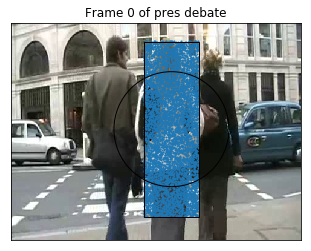

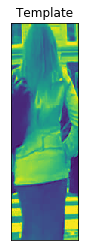

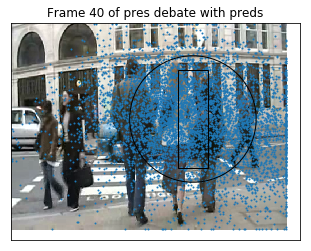

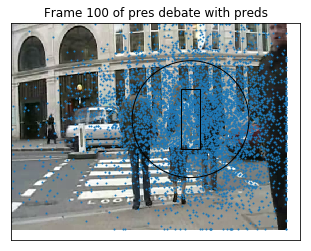

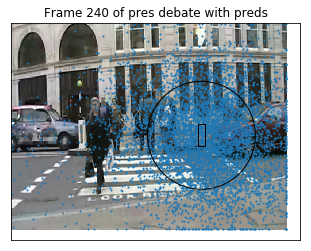

In [65]:
particleFilterDinamycWin([220,30],[90,290],'pedestrians.avi',N=6000,frames=[40,100,240],std=40,sMSE=40,noiseMax=15,alpha=0.085)